In [19]:
import pandas as pd
import numpy as np 

output_dir = "./outputs/"

## Initial Data
Data collected on 04/16

In [20]:
dart_user = pd.read_csv("./data/First/dart_user.csv", header=0)  
token_usage = pd.read_csv("./data/First/token_usage_log.csv")
gpu_power_usage = pd.read_csv("./data/First/GPU Power Usage-data-as-joinbyfield-2025-04-16 11_34_47.csv", header = 1)


# merged 
df = pd.merge(token_usage, dart_user, how='left', left_on='user_id', right_on='user_id')



In [21]:
df['total_tokens'] = df['prompt_tokens'] + df['response_tokens']  

# bucket times into 1 hours intervals
df['time_bucket'] = pd.to_datetime(df['log_date'], format = 'mixed').dt.floor('h')
# group by user_id and time_bucket, then sum the total_tokens
df['day'] = df['time_bucket'].dt.date
# group by day and sum the total_tokens
df['hour'] = df['time_bucket'].dt.hour
# plot token usage by the day 

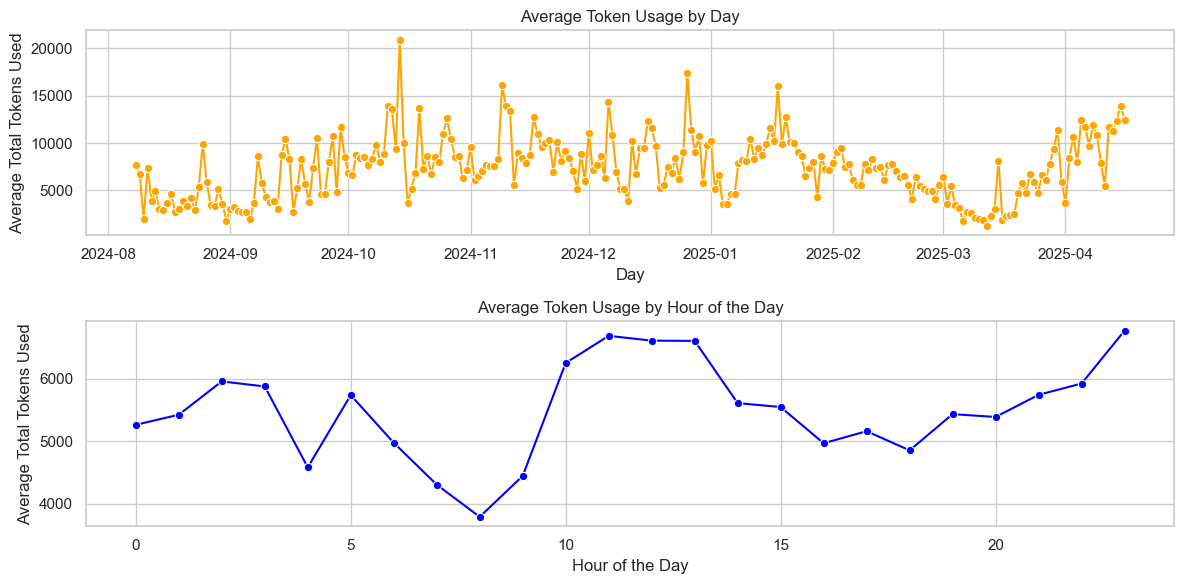

<Figure size 640x480 with 0 Axes>

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by hour and day to calculate mean total tokens
token_usage_hour = df.groupby(['hour']).agg({'total_tokens': 'mean'}).reset_index()
token_usage_day = df.groupby(['day']).agg({'total_tokens': 'mean'}).reset_index()



# Set the style for seaborn plots
sns.set(style="whitegrid")

# Create a figure for the plots
plt.figure(figsize=(12, 6))

# Plot average token usage by day
plt.subplot(2, 1, 1)
sns.lineplot(data=token_usage_day, x='day', y='total_tokens', marker='o', color='orange')
plt.xlabel('Day')
plt.ylabel('Average Total Tokens Used')
plt.title('Average Token Usage by Day')

# Plot average token usage by hour
plt.subplot(2, 1, 2)
sns.lineplot(data=token_usage_hour, x='hour', y='total_tokens', marker='o', color='blue')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Total Tokens Used')
plt.title('Average Token Usage by Hour of the Day')

# Show the plots
plt.tight_layout()
plt.show()

plt.savefig(f"{output_dir}/token_usage_by_day_and_hour.png")

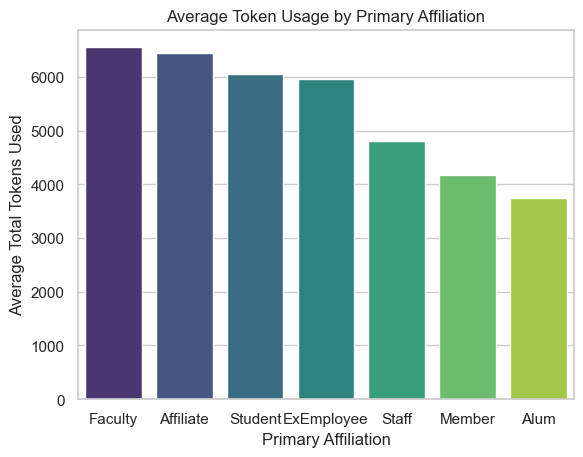

In [23]:
df_affiliation = df.groupby(['primary_affiliation']).agg({'total_tokens': 'mean'}).reset_index()
df_department = df.groupby(['department']).agg({'total_tokens': 'mean'}).reset_index()

df_affiliation = df_affiliation.sort_values(by='total_tokens', ascending=False)
# plot
# Plot average token usage by primary affiliation
sns.barplot(data=df_affiliation, x='primary_affiliation', y='total_tokens', hue = 'primary_affiliation', palette='viridis')
plt.xlabel('Primary Affiliation')
plt.ylabel('Average Total Tokens Used')
plt.title('Average Token Usage by Primary Affiliation')
plt.savefig(f"{output_dir}/token_usage_by_affiliation.png")
pass
# sort



C:\Users\Biratal\AppData\Local\Temp\ipykernel_55068\3923602625.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


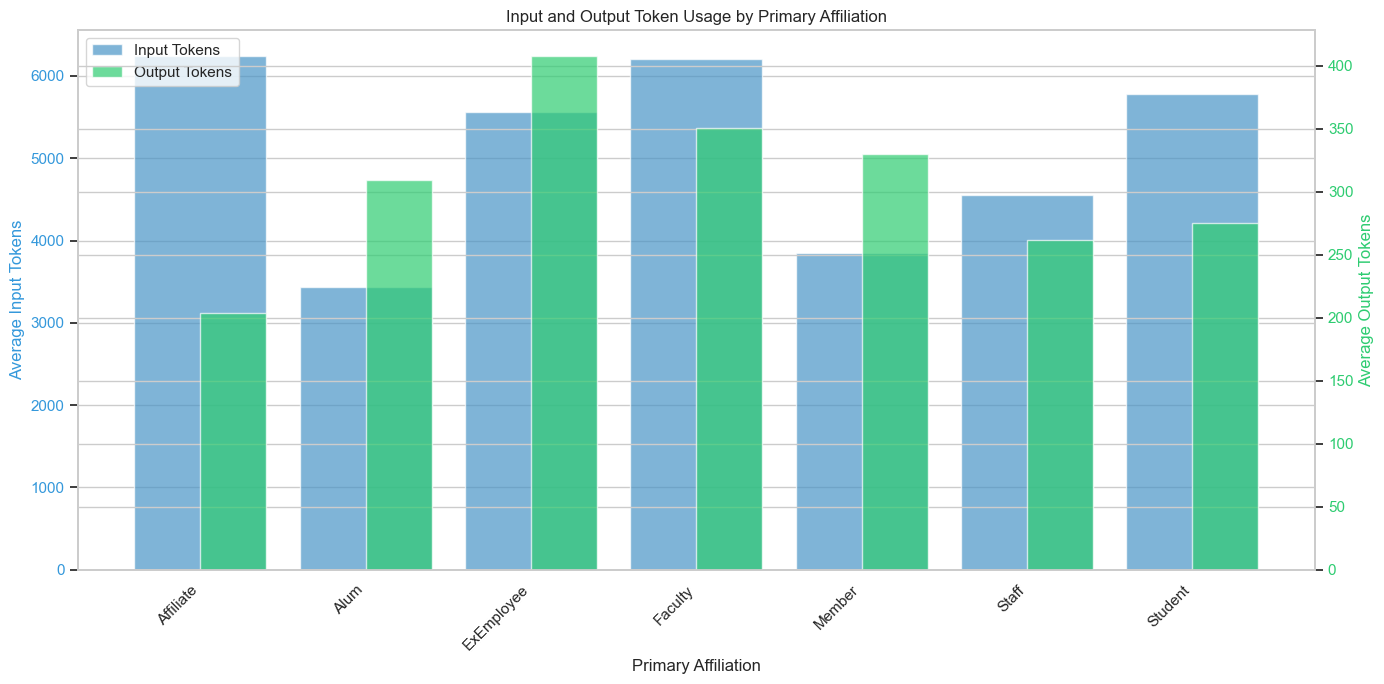

<Figure size 640x480 with 0 Axes>

In [24]:
# First, modify the aggregation to get both input and output tokens
df_affiliation = df.groupby(['primary_affiliation']).agg({
    'prompt_tokens': 'mean',
    'response_tokens': 'mean'
}).reset_index()

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot input tokens on primary axis (left)
color1 = '#3498db'  # Blue
sns.barplot(
    data=df_affiliation,
    x='primary_affiliation',
    y='prompt_tokens',
    color=color1,
    alpha=0.7,
    ax=ax1,
    label='Input Tokens'
)
ax1.set_xlabel('Primary Affiliation')
ax1.set_ylabel('Average Input Tokens', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Create secondary axis (right) sharing the same x-axis
ax2 = ax1.twinx()
color2 = '#2ecc71'  # Green
bar_positions = np.arange(len(df_affiliation))
bar_width = 0.4
ax2.bar(
    bar_positions + bar_width/2,  # Offset bars slightly
    df_affiliation['response_tokens'],
    width=bar_width,
    color=color2,
    alpha=0.7,
    label='Output Tokens'
)
ax2.set_ylabel('Average Output Tokens', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Add title
plt.title('Input and Output Token Usage by Primary Affiliation')

# Add legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

# Show plot with adjusted layout
plt.tight_layout()
plt.show()

plt.savefig(f"{output_dir}/token_usage_by_affiliation_input_output.png")

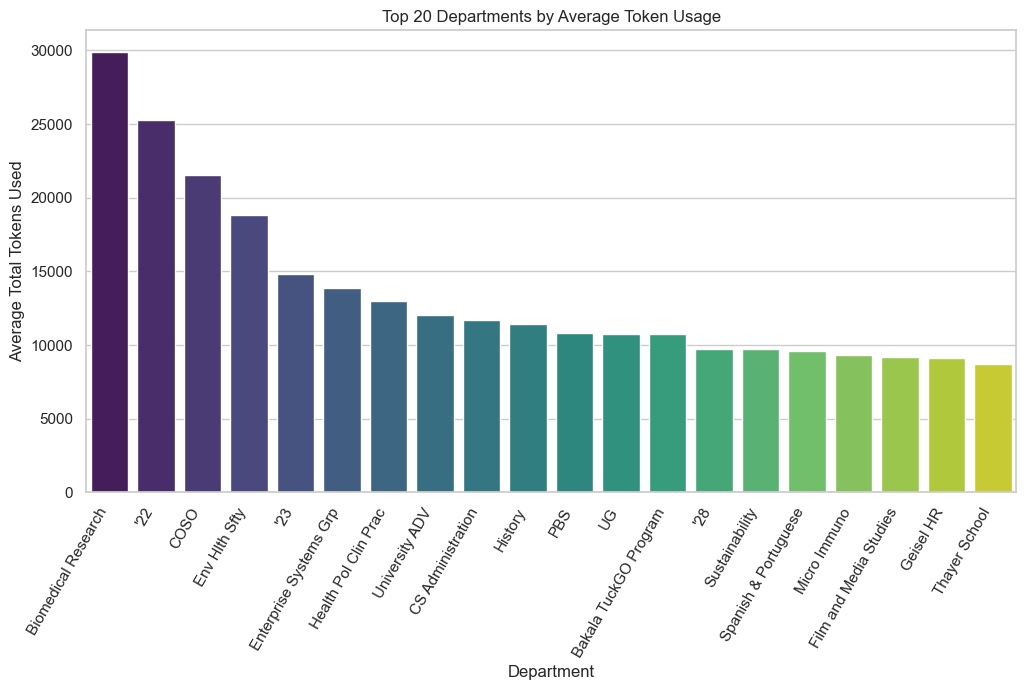

In [25]:
df_department.sort_values(by='total_tokens', ascending=False, inplace=True)
# plot the top 20 departments
plt.figure(figsize=(12, 6))
sns.barplot(data=df_department.head(20), x='department', y='total_tokens', hue = 'department', palette='viridis')
plt.xlabel('Department')
plt.ylabel('Average Total Tokens Used')
plt.title('Top 20 Departments by Average Token Usage')
plt.xticks(rotation=60, ha='right')
pass

plt.savefig(f"{output_dir}/token_usage_by_department.png")

In [33]:

# bucket times into 1 hours intervals
gpu_power_usage['time_bucket'] = pd.to_datetime(gpu_power_usage['Time'], format = 'mixed').dt.floor('h')
gpu_power_usage['day'] = gpu_power_usage['time_bucket'].dt.date
gpu_power_usage['hour'] = gpu_power_usage['time_bucket'].dt.hour
gpu_power_usage['total'] = gpu_power_usage[[x for x in gpu_power_usage.columns if 'GPU' in x]].sum(axis=1)

gpu_power_usage_hour = gpu_power_usage.groupby(['hour']).agg({'total': 'mean'}).reset_index()
gpu_power_usage_day = gpu_power_usage.groupby(['day']).agg({'total': 'mean'}).reset_index()

local_models = ['llama', 'mistral']
token_usage_local = df[df['model'].str.contains('|'.join(local_models))]

token_usage_local_hour = token_usage_local.groupby(['hour']).agg({'total_tokens': 'mean'}).reset_index()
token_usage_local_day = token_usage_local.groupby(['day']).agg({'total_tokens': 'mean'}).reset_index()



In [34]:
token_usage_hour

,hour,total_tokens
0,0,5263.317545
1,1,5424.621469
2,2,5958.997526
3,3,5878.047240
4,4,4580.457910
5,5,5739.313853
6,6,4975.640040
7,7,4303.843570
8,8,3787.572783
9,9,4443.492271


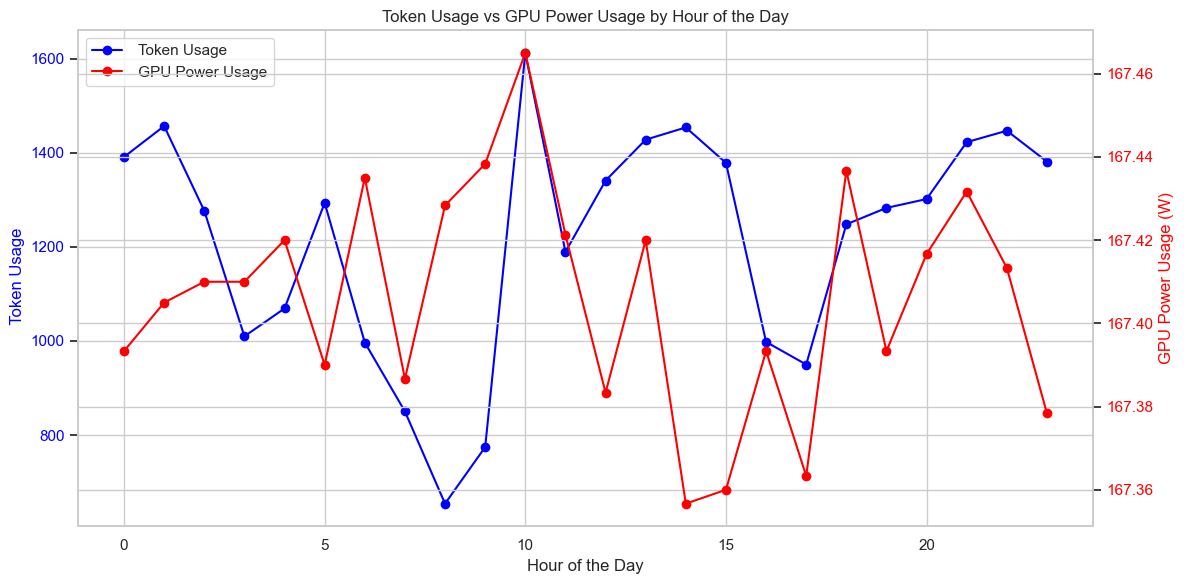

<Figure size 640x480 with 0 Axes>

In [38]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot token usage on primary axis (left)
color = 'blue'
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel(' Token Usage', color=color)
ax1.plot(token_usage_local_hour['hour'], token_usage_local_hour['total_tokens'], 
         marker='o', color=color, label=' Token Usage')
ax1.tick_params(axis='y', labelcolor=color)

# Create secondary axis (right) sharing the same x-axis
ax2 = ax1.twinx()
color = 'red'
ax2.plot(gpu_power_usage_hour['hour'], gpu_power_usage_hour['total'], 
         marker='o', color=color, label=' GPU Power Usage')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('GPU Power Usage (W)', color=color)
# Add title
plt.title('Token Usage vs GPU Power Usage by Hour of the Day')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

plt.savefig(f"{output_dir}/token_usage_vs_gpu_power_usage_by_hour.png")



## Initial Data By models

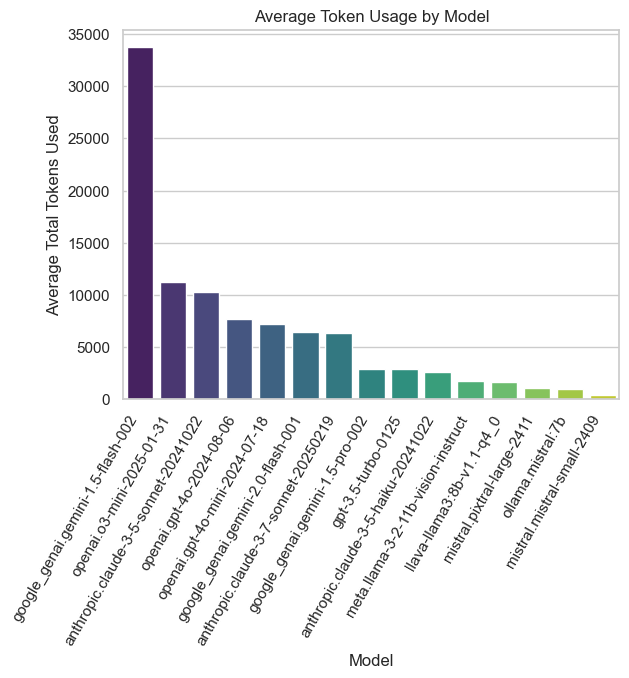

<Figure size 640x480 with 0 Axes>

In [29]:
model_usage = df.groupby(['model']).agg({'total_tokens': 'mean'}).reset_index()
# Plot average token usage by model
model_usage.sort_values(by='total_tokens', ascending=False, inplace=True)

sns.barplot(data=model_usage, x='model', y='total_tokens', hue='model', palette='viridis')
plt.xlabel('Model')
plt.ylabel('Average Total Tokens Used')
plt.title('Average Token Usage by Model')
plt.xticks(rotation=60, ha='right')
plt.show()
# Plot average GPU power usage by model

plt.savefig(f"{output_dir}/token_usage_by_model.png")

In [30]:
token_usage

,log_date,user_id,model,prompt_tokens,response_tokens
0,2025-03-04 08:47:42.338612+00,6d1533cf-5bb3-4c6d-9e90-c34ab31f4d24,openai.gpt-4o-mini-2024-07-18,10950,334
1,2025-03-04 08:49:51.586084+00,6d1533cf-5bb3-4c6d-9e90-c34ab31f4d24,openai.gpt-4o-mini-2024-07-18,11601,115
2,2025-03-04 08:51:13.248849+00,6d1533cf-5bb3-4c6d-9e90-c34ab31f4d24,openai.gpt-4o-mini-2024-07-18,11787,280
3,2025-03-04 08:55:34.705205+00,6d1533cf-5bb3-4c6d-9e90-c34ab31f4d24,openai.gpt-4o-mini-2024-07-18,12095,487
4,2025-03-04 08:57:29.792289+00,6d1533cf-5bb3-4c6d-9e90-c34ab31f4d24,openai.gpt-4o-mini-2024-07-18,13138,322
...,...,...,...,...,...
718844,2025-03-04 09:13:25.219516+00,6d1533cf-5bb3-4c6d-9e90-c34ab31f4d24,openai.gpt-4o-mini-2024-07-18,16368,566
718845,2025-03-04 09:15:47.222315+00,6d1533cf-5bb3-4c6d-9e90-c34ab31f4d24,openai.gpt-4o-mini-2024-07-18,16966,294
718846,2025-03-04 09:16:51.170566+00,6d1533cf-5bb3-4c6d-9e90-c34ab31f4d24,openai.gpt-4o-mini-2024-07-18,17290,314
718847,2025-03-04 09:22:41.679454+00,6d1533cf-5bb3-4c6d-9e90-c34ab31f4d24,openai.gpt-4o-mini-2024-07-18,17943,362


Correlation between input and output token usage: 0.19


C:\Users\Biratal\AppData\Local\Temp\ipykernel_55068\356212852.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  model_correlation = model_correlation.groupby('model').apply(lambda x: x.iloc[0, 3], include_groups = True).reset_index()
C:\Users\Biratal\AppData\Local\Temp\ipykernel_55068\356212852.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_correlation, x='model', y='correlation', palette='viridis')


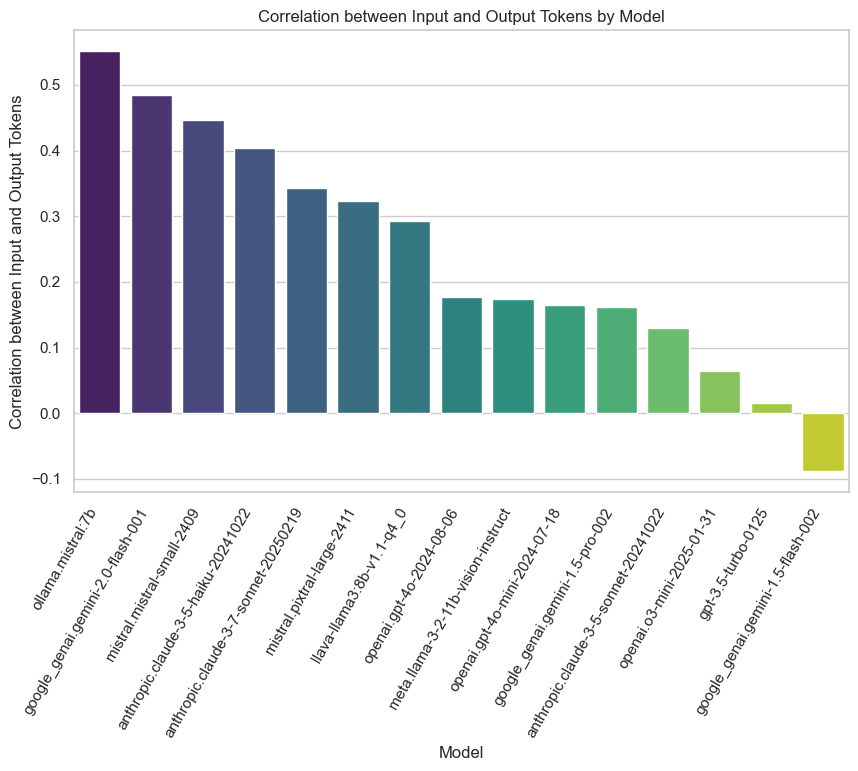

In [31]:
# check correlation between input and output token usage
correlation = df[['prompt_tokens', 'response_tokens']].corr().iloc[0, 1]
print(f"Correlation between input and output token usage: {correlation:.2f}")
# check correlation between input and output token usage by model
model_correlation = df.groupby('model')[['prompt_tokens', 'response_tokens']].corr()
# for each model, have the correlation between input and output token usage
model_correlation = model_correlation.reset_index()
model_correlation = model_correlation[model_correlation['model'] != 'all']
model_correlation = model_correlation.groupby('model').apply(lambda x: x.iloc[0, 3], include_groups = True).reset_index()
model_correlation.columns = ['model', 'correlation']
model_correlation.sort_values(by='correlation', ascending=False, inplace=True)
# plot this
plt.figure(figsize=(10, 6))
sns.barplot(data=model_correlation, x='model', y='correlation', palette='viridis')
plt.xlabel('Model')
plt.ylabel('Correlation between Input and Output Tokens')
plt.title('Correlation between Input and Output Tokens by Model')
plt.xticks(rotation=60, ha='right')


plt.savefig(f"{output_dir}/correlation_input_output_tokens_by_model.png")

# Second Data

In [39]:
gpu_power_usage_2 = pd.read_csv('./data/Second/GPU Power Usage-data-as-joinbyfield-2025-05-08 14_54_19.csv', header=1)
gpu_power_usage_2['total'] = gpu_power_usage_2[[x for x in gpu_power_usage_2.columns if 'GPU' in x]].sum(axis=1)
gpu_power_usage_2['time_bucket'] = pd.to_datetime(gpu_power_usage_2['Time'], format='mixed').dt.floor('h')
gpu_power_usage_2['day'] = gpu_power_usage_2['time_bucket'].dt.date
gpu_power_usage_2['hour'] = gpu_power_usage_2['time_bucket'].dt.hour
# now only have the total power usage
gpu_power_usage_2 = gpu_power_usage_2[['total', 'time_bucket', 'day', 'hour']]
gpu_power_usage_2

,total,time_bucket,day,hour
0,1228.9,2025-04-23 02:00:00,2025-04-23,2
1,1232.3,2025-04-23 03:00:00,2025-04-23,3
2,1227.7,2025-04-23 03:00:00,2025-04-23,3
3,1246.3,2025-04-23 04:00:00,2025-04-23,4
4,1231.9,2025-04-23 04:00:00,2025-04-23,4
...,...,...,...,...
740,1243.4,2025-05-08 12:00:00,2025-05-08,12
741,1241.8,2025-05-08 13:00:00,2025-05-08,13
742,1243.9,2025-05-08 13:00:00,2025-05-08,13
743,1243.9,2025-05-08 14:00:00,2025-05-08,14


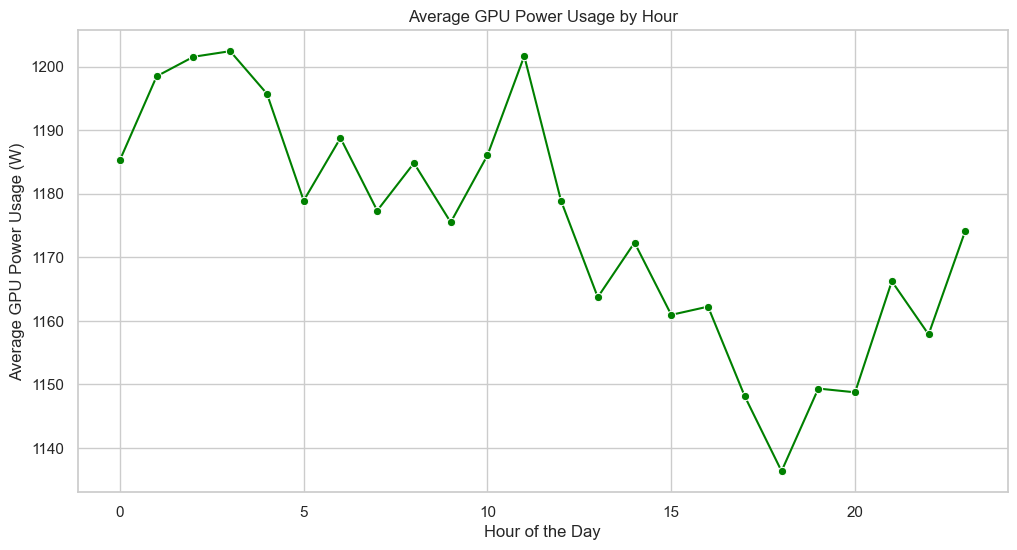

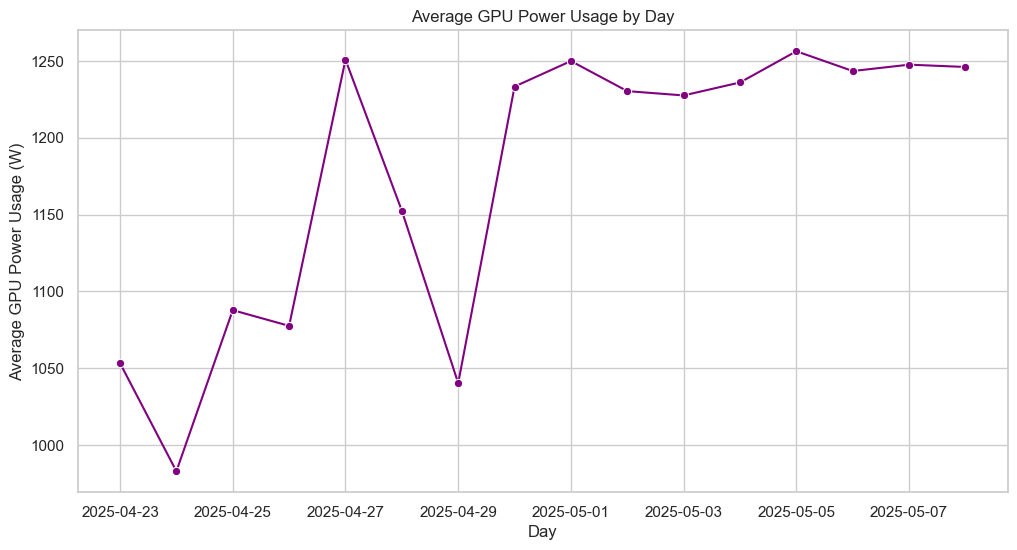

In [40]:
gpu_power_usage_2_hour = gpu_power_usage_2.groupby(['hour']).agg({'total': 'mean'}).reset_index()   
gpu_power_usage_2_day = gpu_power_usage_2.groupby(['day']).agg({'total': 'mean'}).reset_index()

# plot this
plt.figure(figsize=(12, 6))
# Plot average GPU power usage by hour
sns.lineplot(data=gpu_power_usage_2_hour, x='hour', y='total', marker='o', color='green')
plt.xlabel('Hour of the Day')
plt.ylabel('Average GPU Power Usage (W)')
plt.title('Average GPU Power Usage by Hour')


# Plot average GPU power usage by day
plt.figure(figsize=(12, 6))
sns.lineplot(data=gpu_power_usage_2_day, x='day', y='total', marker='o', color='purple')
plt.xlabel('Day')
plt.ylabel('Average GPU Power Usage (W)')
plt.title('Average GPU Power Usage by Day')
# Show the plots

plt.savefig(f"{output_dir}/gpu_power_usage_by_day_and_hour.png")

In [41]:
tensor_core_utilization_2 = pd.read_csv('./data/Second/Tensor Core Utilization-data-as-joinbyfield-2025-05-08 14_56_20.csv', header=1)
# replace nan with 0 
tensor_core_utilization_2['total'] = tensor_core_utilization_2[[x for x in tensor_core_utilization_2.columns if 'GPU' in x]].sum(axis=1)
tensor_core_utilization_2['total'].describe()

count    372.000000
mean       0.041078
std        0.071148
min        0.000000
25%        0.000000
50%        0.000839
75%        0.025038
max        0.225000
Name: total, dtype: float64

# Third

In [42]:
memory_utilization_3 = pd.read_csv('./data/Third/GPU Framebuffer Mem Used-data-as-joinbyfield-2025-05-27 11_13_40.csv', header=1)

gpu_power_usage_3 = pd.read_csv('./data/Third/GPU Power Usage-data-as-joinbyfield-2025-05-27 11_12_32.csv', header=1)

gpu_utilization_3 = pd.read_csv('./data/Third/GPU Utilization-data-as-joinbyfield-2025-05-27 11_13_02.csv', header=1)

tensor_core_utilization_3 = pd.read_csv('./data/Third/Tensor Core Utilization-data-as-joinbyfield-2025-05-27 11_13_15.csv', header=1)

token_usage_3 = pd.read_csv('./data/Third/Token Usage by Affiliation-data-2025-05-27 11_10_12.csv', header=1)

model_usage_3 = pd.read_csv("./data/Third/Token Usage by Model-data-2025-05-27 11_10_26.csv", header=1)
model_usage_3.columns = ['time', 'model', 'total_tokens']


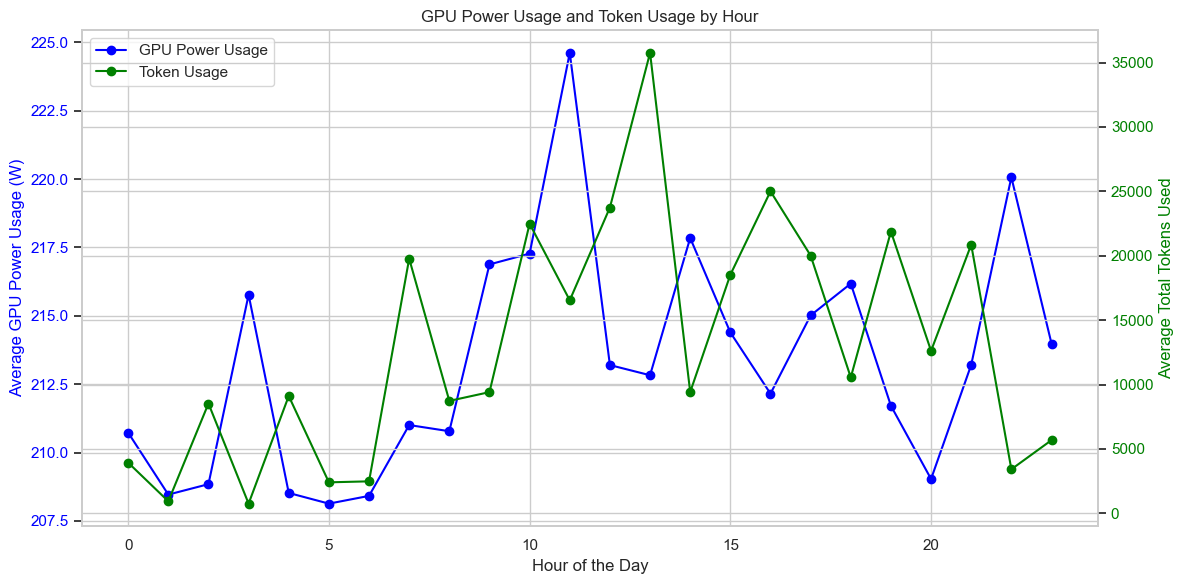

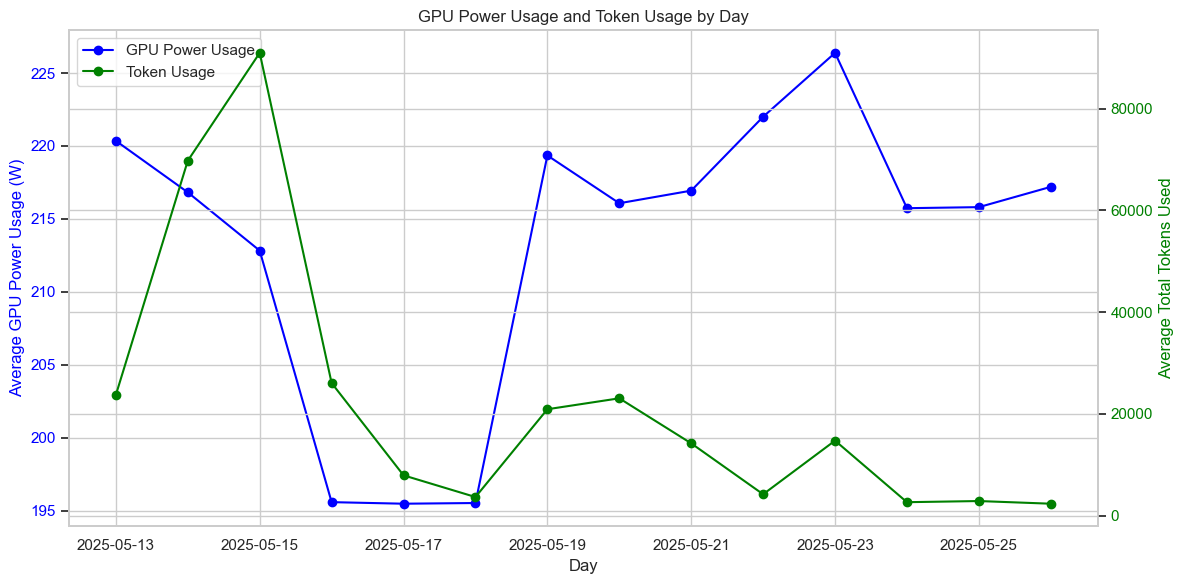

In [62]:
# add up power utilization 
gpu_power_usage_3['total'] = gpu_power_usage_3[[x for x in gpu_power_usage_3.columns if 'GPU' in x]].sum(axis=1)
# bucket times into 1 hours intervals
gpu_power_usage_3['time_bucket'] = pd.to_datetime(gpu_power_usage_3['Time'], format='mixed').dt.floor('h')
gpu_power_usage_3['day'] = gpu_power_usage_3['time_bucket'].dt.date
gpu_power_usage_3['hour'] = gpu_power_usage_3['time_bucket'].dt.hour

# plot 
# Group GPU power usage by hour and day
gpu_power_usage_3_hour = gpu_power_usage_3.groupby(['hour']).agg({'total': 'mean'}).reset_index()
gpu_power_usage_3_day = gpu_power_usage_3.groupby(['day']).agg({'total': 'mean'}).reset_index()

# Plot GPU power usage and token usage by hour
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot GPU power usage on primary axis (left)
color1 = 'blue'
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Average GPU Power Usage (W)', color=color1)
ax1.plot(gpu_power_usage_3_hour['hour'], gpu_power_usage_3_hour['total'], marker='o', color=color1, label='GPU Power Usage')
ax1.tick_params(axis='y', labelcolor=color1)

# Create secondary axis (right) sharing the same x-axis
ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Average Total Tokens Used', color=color2)
ax2.plot(local_model_usage_3_hour['hour'], local_model_usage_3_hour['total_tokens'], marker='o', color=color2, label='Token Usage')
ax2.tick_params(axis='y', labelcolor=color2)

# Add title and legends
plt.title('GPU Power Usage and Token Usage by Hour')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

# Plot GPU power usage and token usage by day
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot GPU power usage on primary axis (left)
color1 = 'blue'
ax1.set_xlabel('Day')
ax1.set_ylabel('Average GPU Power Usage (W)', color=color1)
ax1.plot(gpu_power_usage_3_day['day'], gpu_power_usage_3_day['total'], marker='o', color=color1, label='GPU Power Usage')
ax1.tick_params(axis='y', labelcolor=color1)

# Create secondary axis (right) sharing the same x-axis
ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Average Total Tokens Used', color=color2)
ax2.plot(local_model_usage_3_day['day'], local_model_usage_3_day['total_tokens'], marker='o', color=color2, label='Token Usage')
ax2.tick_params(axis='y', labelcolor=color2)

# Add title and legends
plt.title('GPU Power Usage and Token Usage by Day')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [44]:
# Rename columns to ensure proper aggregation
token_usage_3.columns = ['time', 'metric', 'total_tokens']

# Convert total_tokens to numeric, handling non-numeric values
token_usage_3['total_tokens'] = token_usage_3['total_tokens'].str.replace(r'[^\d.]', '', regex=True).astype(float)

# Plot the affiliation data
affiliation_usage_3 = token_usage_3.groupby(['metric']).agg({'total_tokens': 'mean'}).reset_index()

affiliation_usage_3.columns = ['primary_affiliation', 'total_tokens']



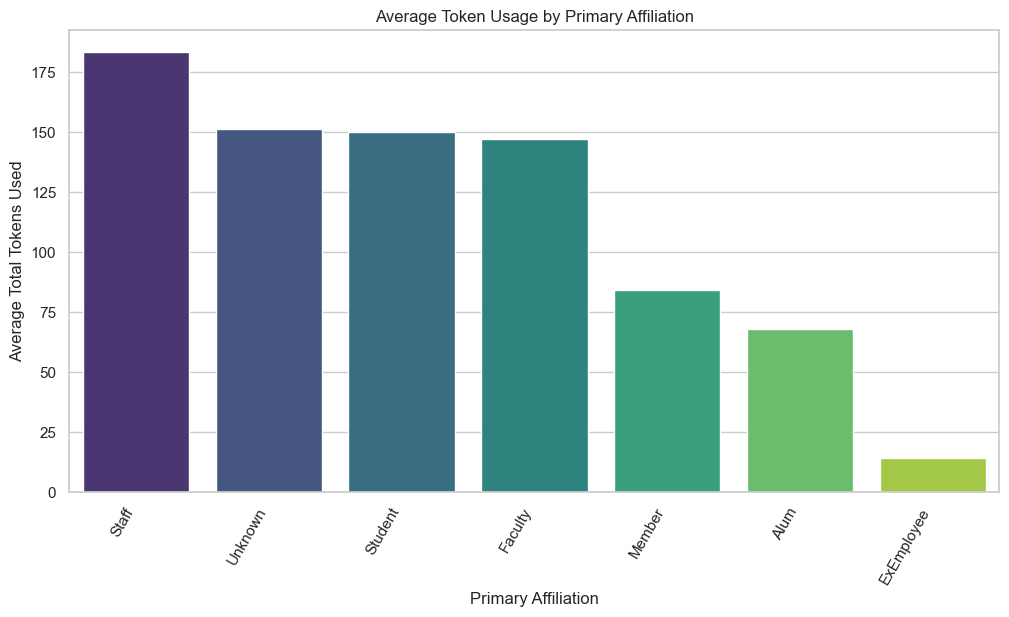

In [45]:
# plot the affiliations
plt.figure(figsize=(12, 6))
affiliation_usage_3 = affiliation_usage_3.sort_values(by='total_tokens', ascending=False)

sns.barplot(data=affiliation_usage_3, x='primary_affiliation', y='total_tokens', hue='primary_affiliation', palette='viridis')
plt.xlabel('Primary Affiliation')
plt.ylabel('Average Total Tokens Used')
plt.title('Average Token Usage by Primary Affiliation')
plt.xticks(rotation=60, ha='right')

plt.savefig(f"{output_dir}/token_usage_by_affiliation_3rd_dataset.png")

In [46]:
# aggregate by model
model_usage_3 = pd.read_csv("./data/Third/Token Usage by Model-data-2025-05-27 11_10_26.csv", header=1)
model_usage_3.columns = ['time', 'model', 'total_tokens']

# lines to convert total_tokens to numeric
set([x[1] if len(x) > 1 else " " for x in model_usage_3.total_tokens.str.split(' ')])
model_usage_3['Unit'] = model_usage_3['total_tokens'].str.extract(r'([KM][a-zA-Z]*)\b')[0]
model_usage_3['Unit'] = [1000 if 'K' in str(x) else 1e6 if 'M' in str(x) else 1 for x in model_usage_3['Unit'].fillna('')]
model_usage_3['number'] = model_usage_3['total_tokens'].str.replace(r'[^\d.]', '', regex=True).astype(float)
model_usage_3['total_tokens'] = model_usage_3['number'] * model_usage_3['Unit']

# based on this if K in string multiply by 1000, else multiply by 1e6
model_usage_3.drop(columns=['number', 'Unit'], inplace=True)

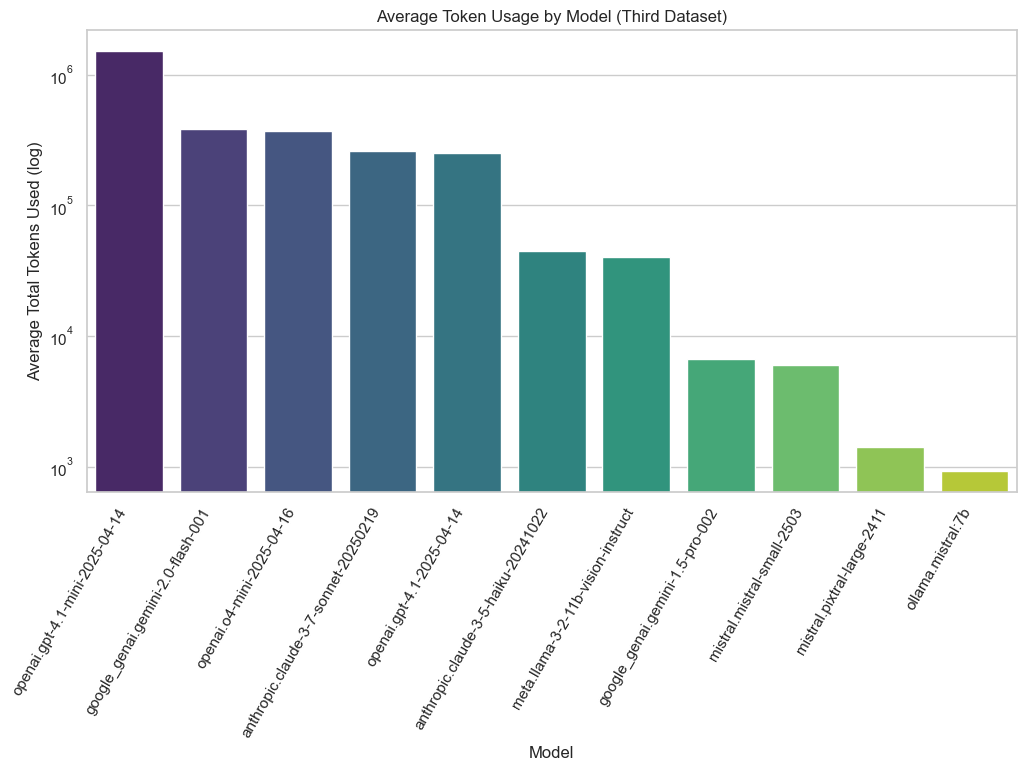

In [47]:
grouped_model_usage_3 = model_usage_3.groupby(['model']).agg({'total_tokens': 'mean'}).reset_index()
grouped_model_usage_3.sort_values(by='total_tokens', ascending=False, inplace=True)
# plot 
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_model_usage_3, x='model', y='total_tokens', hue='model', palette='viridis')
plt.xlabel('Model')
plt.ylabel('Average Total Tokens Used (log)')
plt.title('Average Token Usage by Model (Third Dataset)')
plt.xticks(rotation=60, ha='right')
plt.yscale('log')  # Use logarithmic scale for better visibility
plt.savefig(f"{output_dir}/token_usage_by_model_3rd_dataset.png")


# Local Model With Time

In [48]:
# Things I want to check! 
model_usage_1 = token_usage[['log_date', 'model', 'prompt_tokens', 'response_tokens']]
model_usage_1['total_tokens'] = model_usage_1['prompt_tokens'] + model_usage_1['response_tokens']
model_usage_1.drop(columns=['prompt_tokens', 'response_tokens'], inplace=True)

model_usage_1.columns = ['time', 'model', 'total_tokens']
print(model_usage_1.columns )

model_usage_1['time'] = pd.to_datetime(model_usage_1['time'], format = 'mixed').dt.tz_convert('UTC')
model_usage_1['time'] = pd.to_datetime(model_usage_1['time'], format = 'mixed').dt.floor('h')
model_usage_1['time'] = model_usage_1['time'].dt.tz_localize(None)



# merge the two 
total_data = pd.concat([model_usage_1, model_usage_3], ignore_index=True)


Index(['time', 'model', 'total_tokens'], dtype='object')


In [49]:
total_data['time'] = pd.to_datetime(total_data['time'], format = 'mixed').dt.floor('h')

In [50]:
total_data

,time,model,total_tokens
0,2025-03-04 08:00:00,openai.gpt-4o-mini-2024-07-18,11284.0
1,2025-03-04 08:00:00,openai.gpt-4o-mini-2024-07-18,11716.0
2,2025-03-04 08:00:00,openai.gpt-4o-mini-2024-07-18,12067.0
3,2025-03-04 08:00:00,openai.gpt-4o-mini-2024-07-18,12582.0
4,2025-03-04 08:00:00,openai.gpt-4o-mini-2024-07-18,13460.0
...,...,...,...
721590,2025-05-26 23:00:00,mistral.pixtral-large-2411,98.0
721591,2025-05-26 23:00:00,ollama.mistral:7b,177.0
721592,2025-05-26 23:00:00,openai.gpt-4.1-2025-04-14,399000.0
721593,2025-05-26 23:00:00,openai.gpt-4.1-mini-2025-04-14,2130000.0


In [51]:

# Now process the data
total_data['hour'] = total_data['time'].dt.hour
total_data['day'] = total_data['time'].dt.date  # Extract date portion

# only local models
local_models = ['llama', 'mistral']

total_data = total_data[total_data['model'].str.contains('|'.join(local_models), case=False, na=False)]
total_data


,time,model,total_tokens,hour,day
142,2025-03-04 10:00:00,ollama.mistral:7b,2465.0,10,2025-03-04
143,2025-03-04 10:00:00,ollama.mistral:7b,1993.0,10,2025-03-04
144,2025-03-04 10:00:00,ollama.mistral:7b,3261.0,10,2025-03-04
145,2025-03-04 10:00:00,ollama.mistral:7b,457.0,10,2025-03-04
146,2025-03-04 10:00:00,ollama.mistral:7b,432.0,10,2025-03-04
...,...,...,...,...,...
721580,2025-05-26 22:00:00,ollama.mistral:7b,3440.0,22,2025-05-26
721588,2025-05-26 23:00:00,meta.llama-3-2-11b-vision-instruct,2600.0,23,2025-05-26
721589,2025-05-26 23:00:00,mistral.mistral-small-2503,172.0,23,2025-05-26
721590,2025-05-26 23:00:00,mistral.pixtral-large-2411,98.0,23,2025-05-26


(array([19936., 19967., 19997., 20028., 20058., 20089., 20120., 20148.,
        20179., 20209., 20240.]),
 [Text(19936.0, 0, '2024-08'),
  Text(19967.0, 0, '2024-09'),
  Text(19997.0, 0, '2024-10'),
  Text(20028.0, 0, '2024-11'),
  Text(20058.0, 0, '2024-12'),
  Text(20089.0, 0, '2025-01'),
  Text(20120.0, 0, '2025-02'),
  Text(20148.0, 0, '2025-03'),
  Text(20179.0, 0, '2025-04'),
  Text(20209.0, 0, '2025-05'),
  Text(20240.0, 0, '2025-06')])

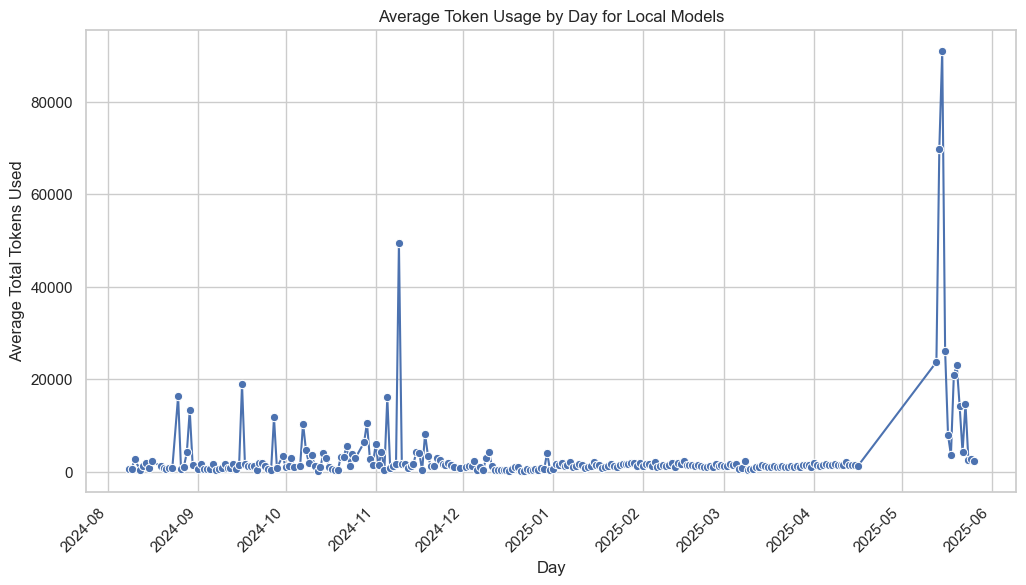

In [52]:

# Group by day and model
total_data_day = total_data.groupby(['day']).agg({'total_tokens': 'mean'}).reset_index()

# Group by hour and model
total_data_hour = total_data.groupby(['hour']).agg({'total_tokens': 'mean'}).reset_index()

# Plot average token usage by day for local models
plt.figure(figsize=(12, 6))
sns.lineplot(data=total_data_day, x='day', y='total_tokens', marker='o')
plt.xlabel('Day')
plt.ylabel('Average Total Tokens Used')
plt.title('Average Token Usage by Day for Local Models')
plt.xticks(rotation=45, ha='right')

In [65]:
gpu_pu_1 = gpu_power_usage[['time_bucket', 'total']]
gpu_pu_2 = gpu_power_usage_2[['time_bucket', 'total']]
gpu_pu_3 = gpu_power_usage_3[['time_bucket', 'total']]

(array([20193., 20200., 20209., 20216., 20223., 20230.]),
 [Text(20193.0, 0, '2025-04-15'),
  Text(20200.0, 0, '2025-04-22'),
  Text(20209.0, 0, '2025-05-01'),
  Text(20216.0, 0, '2025-05-08'),
  Text(20223.0, 0, '2025-05-15'),
  Text(20230.0, 0, '2025-05-22')])

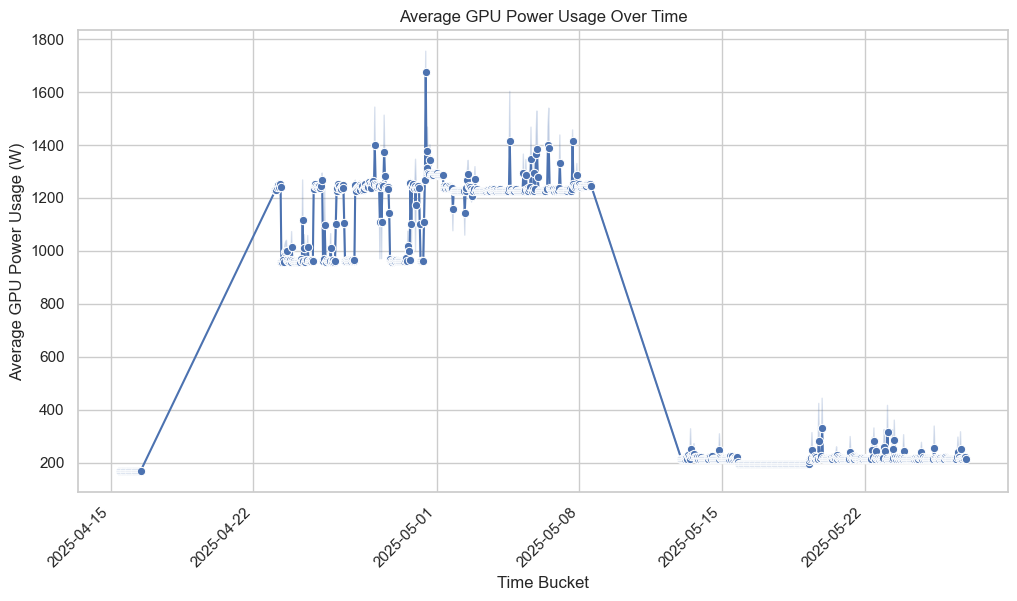

In [66]:
# merge the three dataframes
gpu_pu = pd.concat([gpu_pu_1, gpu_pu_2, gpu_pu_3], ignore_index=True)

# plot this data
plt.figure(figsize=(12, 6))
sns.lineplot(data=gpu_pu, x='time_bucket', y='total', marker='o')
plt.xlabel('Time Bucket')
plt.ylabel('Average GPU Power Usage (W)')
plt.title('Average GPU Power Usage Over Time')
plt.xticks(rotation=45, ha='right')

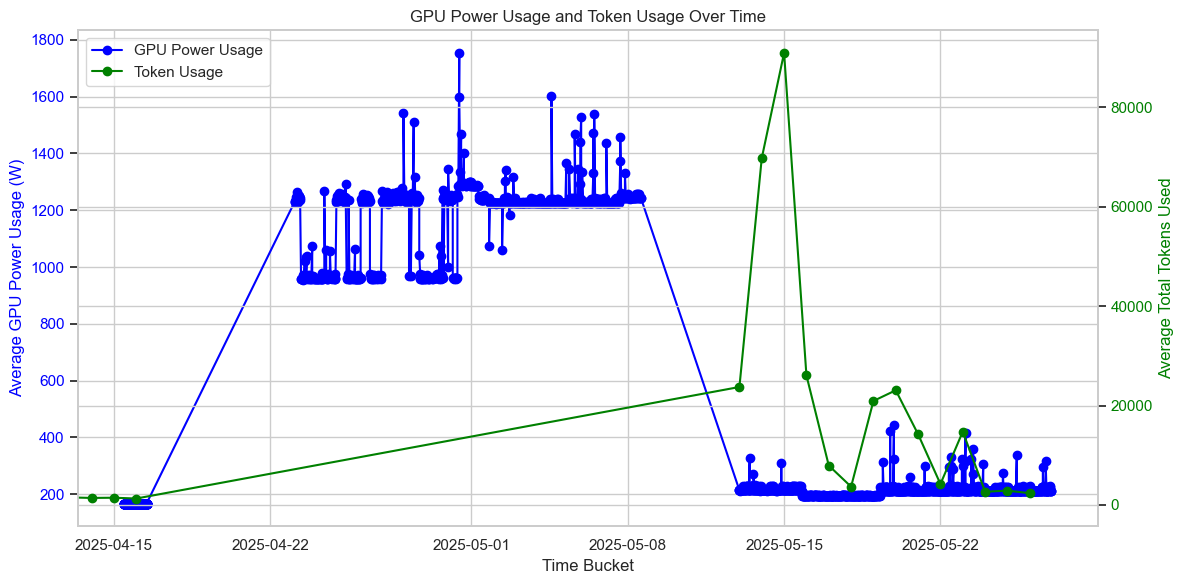

In [55]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot GPU power usage on primary axis (bottom)
color1 = 'blue'
ax1.set_xlabel('Time Bucket')
ax1.set_ylabel('Average GPU Power Usage (W)', color=color1)
ax1.plot(gpu_pu['time_bucket'], gpu_pu['total'], marker='o', color=color1, label='GPU Power Usage')
ax1.tick_params(axis='y', labelcolor=color1)

# Create secondary axis (top) sharing the same x-axis
ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Average Total Tokens Used', color=color2)
ax2.set_xlim(ax1.get_xlim())  # Ensure both x-axes are aligned
ax2.plot(total_data_day['day'], total_data_day['total_tokens'], marker='o', color=color2, label='Token Usage')
ax2.tick_params(axis='y', labelcolor=color2)

# Add title
plt.title('GPU Power Usage and Token Usage Over Time')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

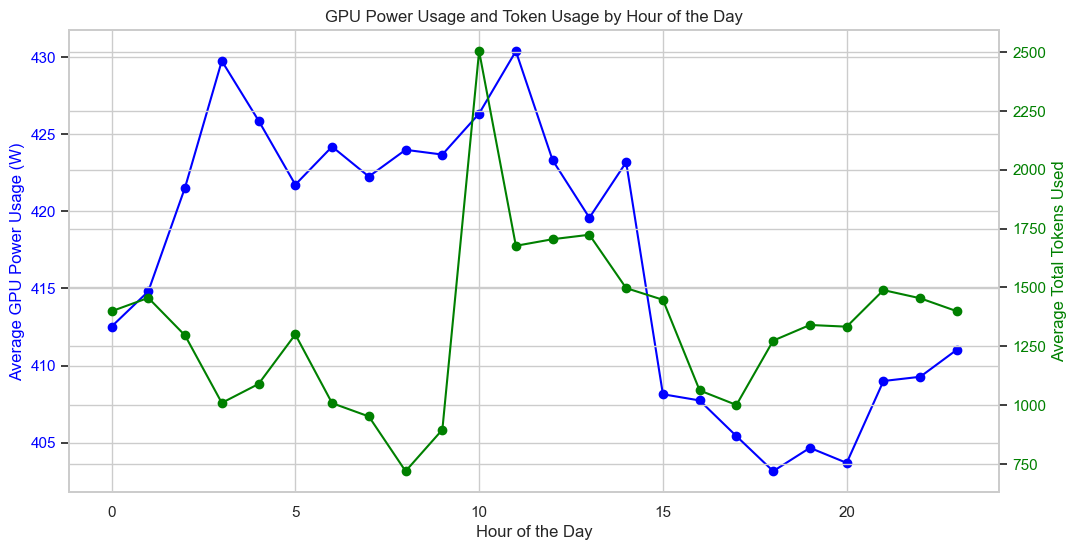

In [69]:
# look at it by hour instead of by day
gpu_pu['hour'] = gpu_pu['time_bucket'].dt.hour
gpu_pu['day'] = gpu_pu['time_bucket'].dt.date

# now aggregate
gpu_pu_hour = gpu_pu.groupby(['hour']).agg({'total': 'mean'}).reset_index()
gpu_pu_day = gpu_pu.groupby(['day']).agg({'total': 'mean'}).reset_index()

# now plot
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))
# Plot GPU power usage on primary axis (bottom)
color1 = 'blue'
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Average GPU Power Usage (W)', color=color1)
ax1.plot(gpu_pu_hour['hour'], gpu_pu_hour['total'], marker='o', color=color1, label='GPU Power Usage')
ax1.tick_params(axis='y', labelcolor=color1)

# Create secondary axis (top) sharing the same x-axis
ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Average Total Tokens Used', color=color2)
ax2.set_xlim(ax1.get_xlim())  # Ensure both x-axes are aligned
ax2.plot(total_data_hour['hour'], total_data_hour['total_tokens'], marker='o', color=color2, label='Token Usage')
ax2.tick_params(axis='y', labelcolor=color2)
# Add title
plt.title('GPU Power Usage and Token Usage by Hour of the Day')

plt.savefig(f"{output_dir}/gpu_power_usage_and_token_usage_by_hour_combined_datasets.png")
